In [1]:
import os
import numpy as np
import xarray as xr;xr.set_options(display_style='text') 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})

import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import * 
from tools.generalTools import *
from tools.BLtools import *
from tools.e5tools import *

import warnings

In [2]:
Ghats      = MountainRangeCustom("ghats",[64,82,7,24],"Western Ghats",None ,[6,7,8],None, path= '/global/cscratch1/sd/qnicolas/regionsDataDeep/')
Ghats.set_daily_imerg()
Ghats.set_daily_Bl_vars('deep')

In [3]:
topo_midres = xr.open_dataarray("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4_coarse.nc")

In [4]:
def get_binned(a,b,bins):
    a,b = np.array(a).reshape(-1),np.array(b).reshape(-1)
    idx = ~np.isnan(b)
    a = a[idx]
    b = b[idx]
    
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    return bin_centers,bin_means

def add_latlon(ax,box,ftz=None):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    
    ax.set_xticks(lons)
    ax.set_xticklabels(lons)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    
    ax.set_xlabel("")
    ax.set_ylabel("")
        

In [5]:
def sel_month(ds,month):
    return ds.sel(time=(ds['time.month']==month))

# Map

Text(0.5, 1.0, 'Ghats Jun-Aug 2001-2020 IMERG rainfall')

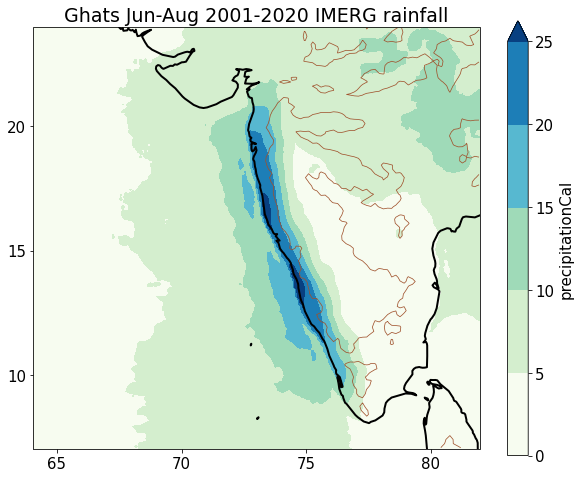

In [6]:
_,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})

ax.coastlines(linewidth=2.)
    
Ghats.vars['GPM_PR_DAILY'].mean('time').transpose('latitude','longitude').plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu)
sel_box(topo_midres,Ghats.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.75],colors=['sienna'])
        
add_latlon(ax,Ghats.box,ftz=14)
ax.set_title('Ghats Jun-Aug 2001-2020 IMERG rainfall',fontsize=19)

# P-BL relationship, daily, by month

In [7]:
precip_all = Ghats.vars['GPM_PR_DAILY'].transpose('time','latitude','longitude').interp_like(Ghats.vars['BLDEEP_DAILY'])
bl_all = Ghats.vars['BLDEEP_DAILY']

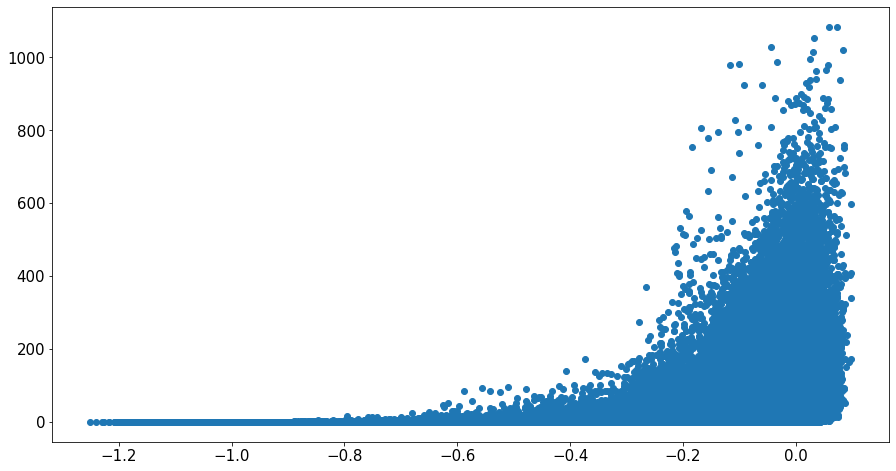

In [8]:
_,ax=plt.subplots(1,1,figsize=(15,8))
ax.scatter(bl_all,precip_all)

In [9]:
bl_bins = np.linspace(-1.2,0.3,201)

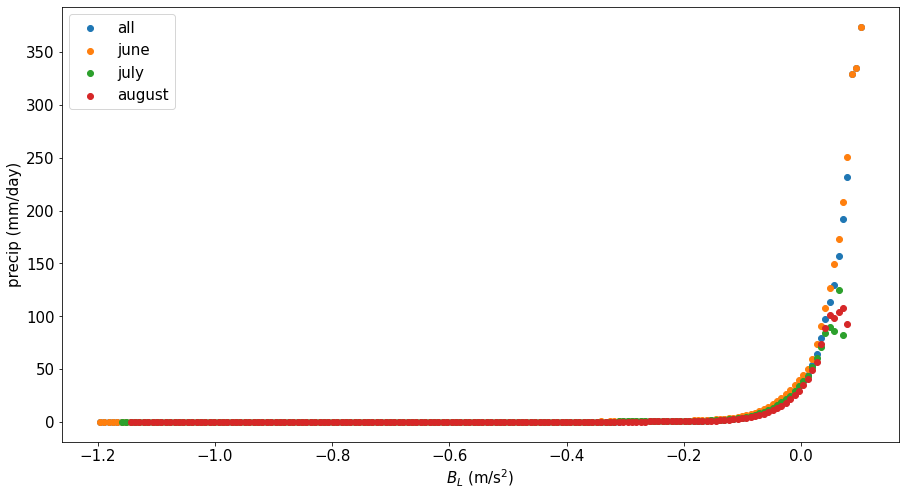

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    _,ax=plt.subplots(1,1,figsize=(15,8))
    ax.scatter(*get_binned(bl_all,precip_all,bl_bins),label='all')
    ax.scatter(*get_binned(sel_month(bl_all,6),sel_month(precip_all,6),bl_bins),label='june')
    ax.scatter(*get_binned(sel_month(bl_all,7),sel_month(precip_all,7),bl_bins),label='july')
    ax.scatter(*get_binned(sel_month(bl_all,8),sel_month(precip_all,8),bl_bins),label='august')
    ax.legend()
    ax.set_ylabel('precip (mm/day)')
    ax.set_xlabel(r'$B_L$ (m/s$^2$)')

# Savannah's interp method

In [6]:
# my era5 data natively comes sorted with decreasing latitude
def reverse_lat(var):
    return var.reindex(latitude=list(reversed(var.latitude)))

In [7]:
pr_june = reverse_lat(Ghats.vars['GPM_PR_DAILY'].sel(time = Ghats.vars['GPM_PR_DAILY']['time.month']==6)).transpose('time','latitude','longitude')
bl_june = reverse_lat(Ghats.vars['BLDEEP_DAILY'].sel(time = Ghats.vars['BLDEEP_DAILY']['time.month']==6))

pr_june_itp_q = pr_june.interp_like(bl_june[0])
pr_june_itp_s = pr_june.interp(longitude = bl_june.longitude,
                               latitude  = bl_june.latitude,
                               method = 'linear'
                              ).interpolate_na(dim=('latitude'),method='linear',fill_value = 'extrapolate'
                                                   ).interpolate_na(dim=('longitude'),method='linear',fill_value = 'extrapolate'
                                                   )

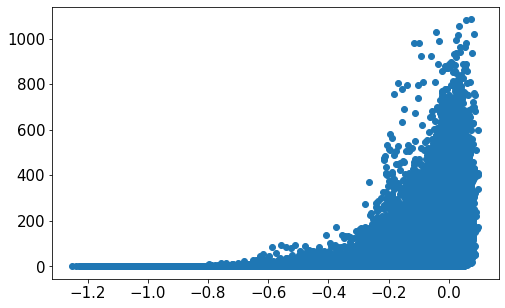

In [8]:
_,ax=plt.subplots(1,1,figsize=(8,5))
ax.scatter(bl_june,pr_june_itp_q)

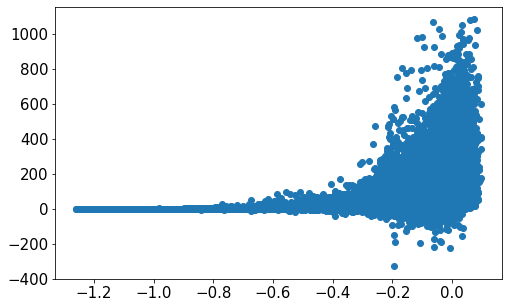

In [9]:
_,ax=plt.subplots(1,1,figsize=(8,5))
ax.scatter(bl_june,pr_june_itp_s)

In [10]:
bl_bins = np.linspace(-1.2,0.3,201)

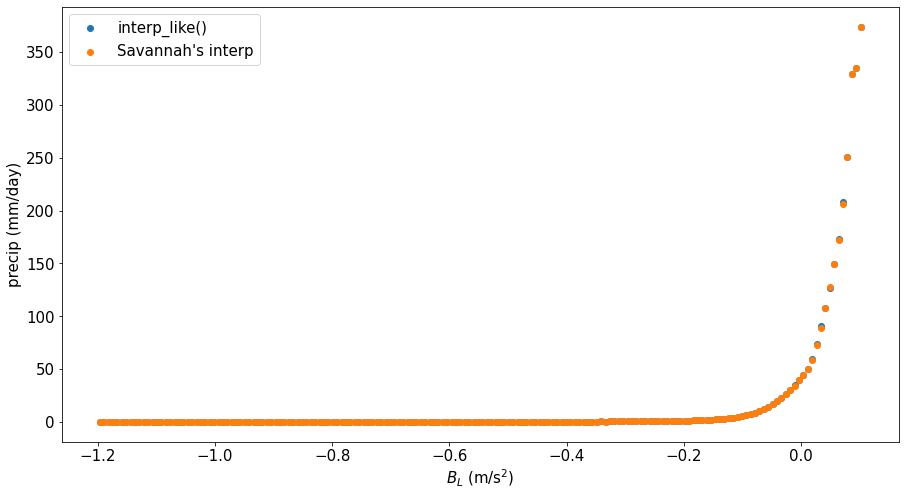

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    _,ax=plt.subplots(1,1,figsize=(15,8))
    ax.scatter(*get_binned(bl_june,pr_june_itp_q,bl_bins),label='interp_like()')
    ax.scatter(*get_binned(bl_june,pr_june_itp_s,bl_bins),label="Savannah's interp")
    ax.legend()
    ax.set_ylabel('precip (mm/day)')
    ax.set_xlabel(r'$B_L$ (m/s$^2$)')

# Calculating BL using Savannah's method

In [12]:
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units

In [14]:
# The following files contain daily era5 t & q data for 2001-2020, only the month of June, and within a box encompassing 
# the Western Ghats: 64-82°E,7-24°N
# Substitute your data here
t = xr.open_dataarray(Ghats.path+'e5.oper.an.pl.128_130_t.ll025sc.2001-2020.06.daily.ghats.nc')
q = xr.open_dataarray(Ghats.path+'e5.oper.an.pl.128_133_q.ll025sc.2001-2020.06.daily.ghats.nc')
p = t.level

In [15]:
%%time
tdew    = mpcalc.dewpoint_from_specific_humidity(q.data*units('kg/kg'),t.data*units.K,p.data[None,:,None,None]*units.hPa)
thetae  = mpcalc.equivalent_potential_temperature(p.data[None,:,None,None]*units.hPa,t.data*units.K,tdew)
thetaes = mpcalc.saturation_equivalent_potential_temperature(p.data[None,:,None,None]*units.hPa,t.data*units.K)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/quantity.py:1393: RuntimeWarning: invalid value encountered in power
  return other ** new_self._magnitude
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in exp
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in multiply
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))


CPU times: user 54.3 s, sys: 31.1 s, total: 1min 25s
Wall time: 1min 25s


In [16]:
#convert back to xarray.DataArray 
xr_structure = t**0
thetae_xr = np.array(thetae/units.K)*xr_structure
thetaes_xr = np.array(thetaes/units.K)*xr_structure

In [17]:
thetaeb = thetae_xr.where(thetae_xr.level>850,drop=True).mean('level')
thetael = thetae_xr.where((thetae_xr.level>=500)&(thetae_xr.level<=850),drop=True).mean('level')
thetaesl = thetaes_xr.where((thetae_xr.level>=500)&(thetaes_xr.level<=850),drop=True).mean('level')

In [18]:
g=9.81
wb = 0.52
wl = 1-wb
capel   = (thetaeb-thetaesl)/thetaesl
subsatl = (thetaesl-thetael)/thetaesl
bl_june_s = g*((wb*capel)-(wl*subsatl))

In [23]:
## Quentin's B_L
bl_june_q = Ghats.vars['BLDEEP_DAILY'].sel(time = Ghats.vars['BLDEEP_DAILY']['time.month']==6)


## B_L pdf

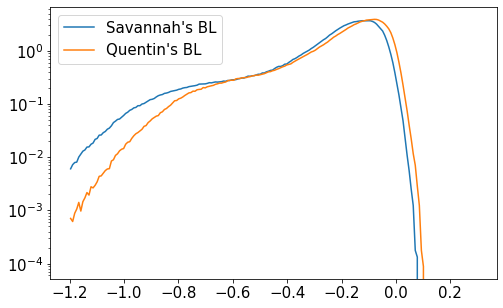

In [34]:
bl_bins = np.linspace(-1.2,0.3,201)
bl_bin_centers = (bl_bins[1:]+bl_bins[:-1])/2
_,ax=plt.subplots(1,1,figsize=(8,5))
ax.plot(bl_bin_centers,np.histogram(bl_june_s,bl_bins,density=True)[0],label="Savannah's BL")
ax.plot(bl_bin_centers,np.histogram(bl_june_q,bl_bins,density=True)[0],label="Quentin's BL")
ax.set_yscale('log')
ax.legend()

## B_L - precip relationship

In [24]:
pr_june = Ghats.vars['GPM_PR_DAILY'].sel(time = Ghats.vars['GPM_PR_DAILY']['time.month']==6).transpose('time','latitude','longitude').interp_like(bl_june_q[0])
thresh = 0.06

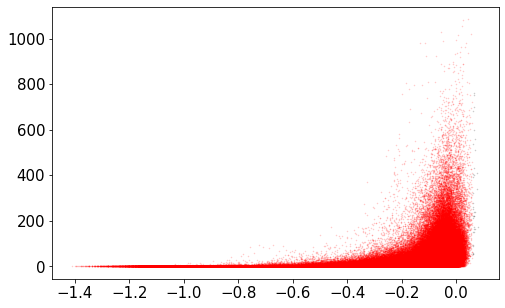

In [25]:
_,ax=plt.subplots(1,1,figsize=(8,5))
ax.scatter(bl_june_s.where(bl_june_s<=thresh),pr_june.where(bl_june_s<=thresh),marker='.',s=1,alpha=0.2,color='r')
ax.scatter(bl_june_s.where(bl_june_s> thresh),pr_june.where(bl_june_s> thresh),marker='.',s=1,alpha=0.2,color='k')

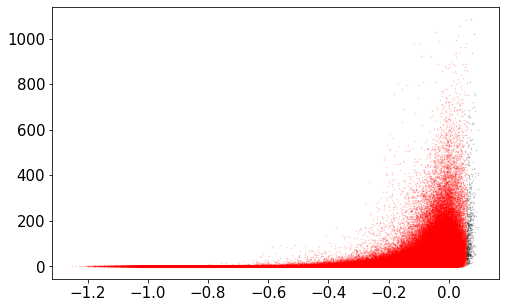

In [26]:
_,ax=plt.subplots(1,1,figsize=(8,5))
ax.scatter(bl_june_q.where(bl_june_q<=thresh),pr_june.where(bl_june_q<=thresh),marker='.',s=1,alpha=0.2,color='r')
ax.scatter(bl_june_q.where(bl_june_q> thresh),pr_june.where(bl_june_q> thresh),marker='.',s=1,alpha=0.2,color='k')

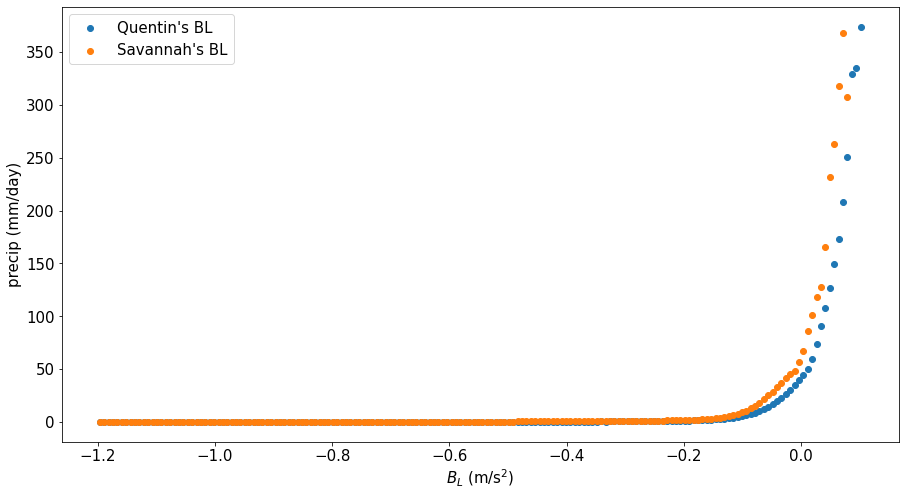

In [28]:
bl_bins = np.linspace(-1.2,0.3,201)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    _,ax=plt.subplots(1,1,figsize=(15,8))
    ax.scatter(*get_binned(bl_june_q,pr_june,bl_bins),label="Quentin's BL")
    ax.scatter(*get_binned(bl_june_s,pr_june,bl_bins),label="Savannah's BL")
    ax.legend()
    ax.set_ylabel('precip (mm/day)')
    ax.set_xlabel(r'$B_L$ (m/s$^2$)')